# Prevendo o Nível de Satisfação dos Clientes do Santander

Sábado, 6 de novembro de 2021

## Definição do Problema:

Indentificar os clientes que estão insatisfeitos com os serviços bancarios do Banco Santander com uma precisão de pelo menos 70% utilizando de todos os recursos disponiveis na linguagem Python

# Importação dos pacotes necessarios

In [1]:
# Realizando importações do pacote
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import sklearn as sk
from sklearn.feature_selection import VarianceThreshold
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from imblearn.under_sampling import NearMiss
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_selection import RFE

# Importação dos Dados

In [2]:
# Carregando dados de treino.
treino = pd.read_csv('dataset/train.csv')

# Carregando dados de teste.
teste = pd.read_csv('dataset/test.csv')

# Analise Exploratoria dos Dados

In [3]:
# Imprimindo informações basicas do Dataset

# Imprimindo shape do Dataset
print("O shape do Dataset é:", treino.shape)
print('')

# Imprimindo o nome das colunas
for col in treino.columns:
    print(col)

O shape do Dataset é: (76020, 371)

ID
var3
var15
imp_ent_var16_ult1
imp_op_var39_comer_ult1
imp_op_var39_comer_ult3
imp_op_var40_comer_ult1
imp_op_var40_comer_ult3
imp_op_var40_efect_ult1
imp_op_var40_efect_ult3
imp_op_var40_ult1
imp_op_var41_comer_ult1
imp_op_var41_comer_ult3
imp_op_var41_efect_ult1
imp_op_var41_efect_ult3
imp_op_var41_ult1
imp_op_var39_efect_ult1
imp_op_var39_efect_ult3
imp_op_var39_ult1
imp_sal_var16_ult1
ind_var1_0
ind_var1
ind_var2_0
ind_var2
ind_var5_0
ind_var5
ind_var6_0
ind_var6
ind_var8_0
ind_var8
ind_var12_0
ind_var12
ind_var13_0
ind_var13_corto_0
ind_var13_corto
ind_var13_largo_0
ind_var13_largo
ind_var13_medio_0
ind_var13_medio
ind_var13
ind_var14_0
ind_var14
ind_var17_0
ind_var17
ind_var18_0
ind_var18
ind_var19
ind_var20_0
ind_var20
ind_var24_0
ind_var24
ind_var25_cte
ind_var26_0
ind_var26_cte
ind_var26
ind_var25_0
ind_var25
ind_var27_0
ind_var28_0
ind_var28
ind_var27
ind_var29_0
ind_var29
ind_var30_0
ind_var30
ind_var31_0
ind_var31
ind_var32_cte
ind_var3

In [4]:
# Verificando se todas as variaveis estão no tipo numerico
numericas = []
for col in treino.columns:
    if treino[col].dtype == 'int64' or treino[col].dtype == 'float64':
        continue
    else:
        numericas.append(str(col))
print('Verificação concluida, foi encontradas {} colunas que não são numericas'.format(len(numericas)))

Verificação concluida, foi encontradas 0 colunas que não são numericas


In [5]:
# Excluindo a variavel ID do Dataset de treino
df = treino.drop('ID', axis = 1)

In [6]:
# Eliminando a variável ID, do dataset de teste.
VarTeste = teste.drop('ID', axis = 1)

# Coletando a variavel teste no meu Dataset de teste
testeID = teste.ID

In [7]:
# Verificando se existe valores vazios no Dataset
df.isnull().sum().sum()

0

In [8]:
# Verificando se existe valores duplicados
df.duplicated().sum()

4807

In [9]:
# Eliminando os registros duplicados, do dataset de treino.
df = df.drop_duplicates()

In [10]:
# Verificando quais variaveis possuem dados que variam, ou seja não constantes.
# Pois se os dados não mudam, não é possivel localizar um padrão.
VarConstante = []
for col in df.columns:
    if len(df[col].value_counts()) == 1:
        VarConstante.append(col)
    else:
        continue

print('Verificação concluida, foi encontradas {} colunas que seus dados são constantes'.format(len(VarConstante)))

Verificação concluida, foi encontradas 34 colunas que seus dados são constantes


In [11]:
# Imprimindo o nome das colunas que possuem dados constantes
print(VarConstante)

['ind_var2_0', 'ind_var2', 'ind_var27_0', 'ind_var28_0', 'ind_var28', 'ind_var27', 'ind_var41', 'ind_var46_0', 'ind_var46', 'num_var27_0', 'num_var28_0', 'num_var28', 'num_var27', 'num_var41', 'num_var46_0', 'num_var46', 'saldo_var28', 'saldo_var27', 'saldo_var41', 'saldo_var46', 'imp_amort_var18_hace3', 'imp_amort_var34_hace3', 'imp_reemb_var13_hace3', 'imp_reemb_var33_hace3', 'imp_trasp_var17_out_hace3', 'imp_trasp_var33_out_hace3', 'num_var2_0_ult1', 'num_var2_ult1', 'num_reemb_var13_hace3', 'num_reemb_var33_hace3', 'num_trasp_var17_out_hace3', 'num_trasp_var33_out_hace3', 'saldo_var2_ult1', 'saldo_medio_var13_medio_hace3']


In [12]:
# Excluindo essas colunas do dataset
df = df.drop(columns = VarConstante)

# imprimindo o novo Dataset
print('Shape do novo dataset é:', df.shape)

Shape do novo dataset é: (71213, 336)


In [13]:
# verificando quais variaveis são perfeitamente correlacionadas.
# Ou seja correlação = [-1, 1]

# Criando a matriz de correlação
corr = df.drop('TARGET', axis = 1).corr()

# Vou deixar os numeros da matriz da correlação em formato absoluto
corr.abs()

# Selecionando o triângulo superior, da matriz de correlação.
upper = corr.where(np.triu(np.ones(corr.shape), k = 1).astype(np.bool))

# Encontrando os índices das variáveis perfeitamente correlacionadas (correlação igual a 1).
per_corr = [column for column in upper.columns if any(upper[column] == 1)]

In [14]:
# Verificando as variaveis perfeitamente correlacionadas
per_corr

['ind_var13_medio',
 'ind_var18',
 'ind_var26',
 'ind_var25',
 'ind_var29_0',
 'ind_var29',
 'ind_var32',
 'ind_var34',
 'ind_var37',
 'ind_var39',
 'num_var13_medio',
 'num_var18',
 'num_var26',
 'num_var25',
 'num_var29_0',
 'num_var29',
 'num_var32',
 'num_var34',
 'num_var37',
 'num_var39',
 'saldo_var29',
 'delta_num_aport_var17_1y3',
 'delta_num_aport_var33_1y3',
 'delta_num_reemb_var13_1y3',
 'delta_num_reemb_var17_1y3',
 'delta_num_reemb_var33_1y3',
 'delta_num_trasp_var17_in_1y3',
 'delta_num_trasp_var17_out_1y3',
 'delta_num_trasp_var33_in_1y3',
 'delta_num_trasp_var33_out_1y3',
 'num_meses_var13_medio_ult3',
 'saldo_medio_var13_medio_ult1']

In [15]:
# Excluindo essas colunas do dataset
df = df.drop(columns = per_corr)

# imprimindo o novo Dataset
print('Shape do novo dataset é:', df.shape)

Shape do novo dataset é: (71213, 304)


In [16]:
# O threshold = 0.01, indica que os recursos com uma variância do conjunto de treinamento inferior a este limite, 
# serão removidos (são recursos quasi-constantes).
vt = VarianceThreshold(threshold = 0.01)  

# Treinando o modelo, para encontrar as variáveis com baixa variância.
vt.fit(df.drop(labels = ['TARGET'], axis = 1)) 

# Capturando o nome das variáveis, que não são quasi-constantes, no dataset de treino.
constantFeatures = df.drop(labels = ['TARGET'], axis = 1).columns[vt.get_support()]

# Capturando o nome das variáveis, que são quasi-constantes, no dataset de treino.
quasiConstantFeatures = [f for f in df.drop(labels = ['TARGET'], axis = 1).columns if f not in constantFeatures]

In [17]:
print(quasiConstantFeatures)

['ind_var1', 'ind_var6_0', 'ind_var6', 'ind_var13_medio_0', 'ind_var14', 'ind_var17_0', 'ind_var17', 'ind_var18_0', 'ind_var19', 'ind_var20_0', 'ind_var20', 'ind_var30_0', 'ind_var31_0', 'ind_var31', 'ind_var32_cte', 'ind_var32_0', 'ind_var33_0', 'ind_var33', 'ind_var34_0', 'ind_var40', 'ind_var44_0', 'ind_var44', 'num_var6_0', 'num_var6', 'num_var13_medio_0', 'num_var18_0', 'num_var33', 'num_var34_0', 'ind_var7_emit_ult1', 'ind_var7_recib_ult1', 'num_aport_var33_hace3', 'num_aport_var33_ult1', 'num_var7_emit_ult1', 'num_meses_var17_ult3', 'num_meses_var29_ult3', 'num_meses_var33_ult3', 'num_meses_var44_ult3', 'num_reemb_var13_ult1', 'num_reemb_var17_hace3', 'num_reemb_var33_ult1', 'num_trasp_var17_in_hace3', 'num_trasp_var17_in_ult1', 'num_trasp_var17_out_ult1', 'num_trasp_var33_in_hace3', 'num_trasp_var33_in_ult1', 'num_trasp_var33_out_ult1', 'num_venta_var44_hace3']


In [18]:
# Eliminando as variáveis quasi-constantes, do dataset de treino.
df = df.drop(quasiConstantFeatures, axis = 1)
## Verificando a variavel target
# imprimindo o novo Dataset
print('Shape do novo dataset é:', df.shape)

Shape do novo dataset é: (71213, 257)


## Verificando a variavel target

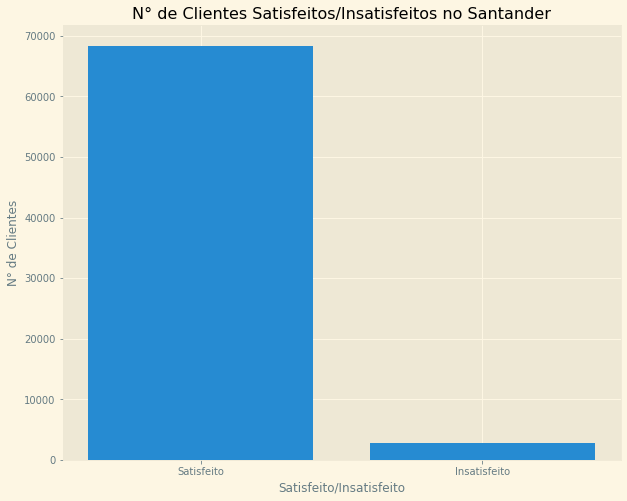

In [19]:
grupos = ['Satisfeito', 'Insatisfeito']
valores = df['TARGET'].value_counts().values

# Construção do gráfico
plt.style.use("Solarize_Light2")
plt.figure(figsize = [10, 8])
plt.bar(grupos, valores)
plt.title('N° de Clientes Satisfeitos/Insatisfeitos no Santander')
plt.ylabel('N° de Clientes')
plt.xlabel('Satisfeito/Insatisfeito')
plt.show()

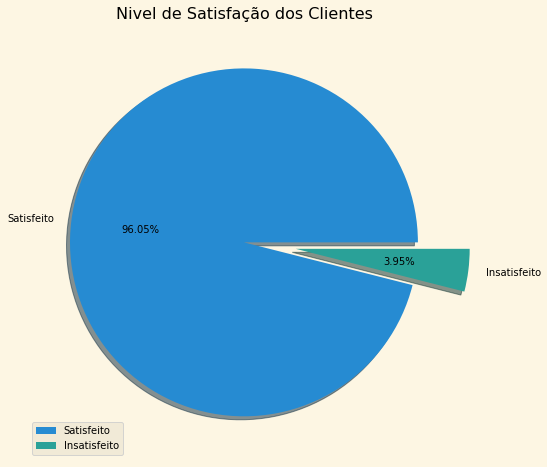

In [20]:
# define o nível de separabilidade entre as partes, ordem do vetor representa as partes
explode = (0, 0.3) 

# define o formato de visualização com saída em 1.1%%, sombras e a separação entre as partes
plt.figure(figsize = [10, 8])
plt.pie(valores, labels=grupos, autopct='%1.2f%%', shadow=True, explode=explode)

# inseri a legenda e a localização da legenda.
plt.legend(grupos, loc=3)
plt.title('Nivel de Satisfação dos Clientes')
plt.show()

## Transformações nos Dados

In [21]:
# Separando a variável target, das features do conjunto de dados.
VarTreino, targetTreino = df.drop('TARGET', axis = 1), np.array(df.TARGET).ravel()

### Realizando normalização nos Dados

In [22]:
scaler = MinMaxScaler()

# Aplicando a escala no Dataset
VarTreinoNormalizadas = scaler.fit_transform(VarTreino)

# Criando um DataFrame com os resultados obtidos.
VarTreinoNormalizadas = pd.DataFrame(data = VarTreinoNormalizadas, columns = VarTreino.columns)

VarTreinoNormalizadas.head()

,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,imp_op_var40_ult1,...,saldo_medio_var29_ult3,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38
0,0.999764,0.18,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001545
1,0.999764,0.29,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.002003
2,0.999764,0.18,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.002822
3,0.999764,0.32,0.0,0.01513,0.009275,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.002671
4,0.999764,0.34,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.005091


### Realizando Padronização nos Dados

In [23]:
Standard = StandardScaler()

# Aplicando a escala no Dataset
VarTreinoPadronizadas = Standard.fit_transform(VarTreino)

# Criando um DataFrame com os resultados obtidos.
VarTreinoPadronizadas = pd.DataFrame(data = VarTreinoPadronizadas, columns = VarTreino.columns)

VarTreinoPadronizadas.head()

,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,imp_op_var40_ult1,...,saldo_medio_var29_ult3,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38
0,0.038772,-0.805834,-0.055166,-0.220682,-0.226444,-0.039477,-0.043503,-0.013941,-0.016054,-0.03428,...,-0.006049,-0.017986,-0.012377,-0.016115,-0.016856,-0.01617,-0.012994,-0.019442,-0.020506,-0.414017
1,0.038772,0.033327,-0.055166,-0.220682,-0.226444,-0.039477,-0.043503,-0.013941,-0.016054,-0.03428,...,-0.006049,-0.017986,-0.012377,-0.016115,-0.016856,-0.01617,-0.012994,-0.019442,-0.020506,-0.360503
2,0.038772,-0.805834,-0.055166,-0.220682,-0.226444,-0.039477,-0.043503,-0.013941,-0.016054,-0.03428,...,-0.006049,-0.017986,-0.012377,-0.016115,-0.016856,-0.01617,-0.012994,-0.019442,-0.020506,-0.264577
3,0.038772,0.262189,-0.055166,0.336397,0.119616,-0.039477,-0.043503,-0.013941,-0.016054,-0.03428,...,-0.006049,-0.017986,-0.012377,-0.016115,-0.016856,-0.01617,-0.012994,-0.019442,-0.020506,-0.282246
4,0.038772,0.414763,-0.055166,-0.220682,-0.226444,-0.039477,-0.043503,-0.013941,-0.016054,-0.03428,...,-0.006049,-0.017986,-0.012377,-0.016115,-0.016856,-0.01617,-0.012994,-0.019442,-0.020506,0.000940


# Feature Selection

###  Eliminação Recursiva de Atributos

Esta é uma técnica para seleção de atributos, que recursivamente remove os atributos e constrói o modelo com os atributos remanescentes. Esta técnica utiliza a acurácia do modelo para identificar os atributos que mais contribuem para prever a variável alvo. Em inglês esta técnia é chamada Recursive Feature Elimination (RFE).

In [24]:
# Para a utilização correta da ferramenta, irei utilizar os dados NORMALIZADOS
X = VarTreinoNormalizadas
Y = targetTreino

# Criando a instancia da ferramenta para selecionar as top 5 variaveis
rfe = RFE (estimator= xgb.XGBClassifier(), 
    n_features_to_select = 5)

# Realizando o treinamento
rfeFit = rfe.fit (X = X, 
                  y = Y)

In [25]:
# Capturando o nome das melhores variáveis preditoras.
rfeVAR = X.columns[rfeFit.support_]

# Exibindo o nome das melhores variáveis preditoras.
rfeVAR

Index(['var15', 'ind_var26_cte', 'num_var42_0', 'saldo_var30',
       'saldo_medio_var5_hace2'],
      dtype='object')

# Analise Preditiva / Avaliação de Perfomance

### Dados sem Transformação

#### Separação dos Dados Entre Treino e Teste

In [26]:
# Carregando os dados
array = VarTreino[rfeVAR].values

# Separando o array em componentes de input e output
X = array[:,0:5]
Y = targetTreino

# Definindo os valores para os folds
num_folds = 10
seed = 7

# Separando os dados em folds
kfold = KFold(num_folds, True, random_state = seed)

##### Realizando os testes com diversos modelos classificativos

LR: 0.955401 (0.002398)
LDA: 0.960401 (0.002434)
NB: 0.959319 (0.002674)
KNN: 0.956061 (0.002888)
CART: 0.949602 (0.002751)
SVM: 0.960471 (0.002493)
XGBoost: 0.960288 (0.002550)


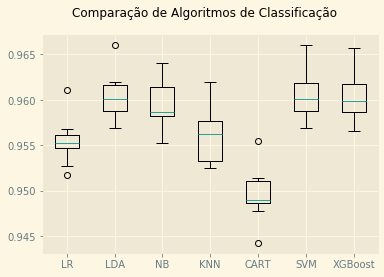

In [27]:
# Preparando a lista de modelos
modelos = []
modelos.append(('LR', LogisticRegression()))
modelos.append(('LDA', LinearDiscriminantAnalysis()))
modelos.append(('NB', GaussianNB()))
modelos.append(('KNN', KNeighborsClassifier()))
modelos.append(('CART', DecisionTreeClassifier()))
modelos.append(('SVM', SVC()))
modelos.append(('XGBoost', xgb.XGBClassifier()))

# Avaliando cada modelo em um loop
resultados = []
nomes = []

for nome, modelo in modelos:
    kfold = KFold(n_splits = num_folds, random_state = seed)
    cv_results = cross_val_score(modelo, X, Y, cv = kfold, scoring = 'accuracy')
    resultados.append(cv_results)
    nomes.append(nome)
    msg = "%s: %f (%f)" % (nome, cv_results.mean(), cv_results.std())
    print(msg)

# Boxplot para comparar os algoritmos
fig = plt.figure()
fig.suptitle('Comparação de Algoritmos de Classificação')
ax = fig.add_subplot(111)
plt.boxplot(resultados)
ax.set_xticklabels(nomes)
plt.show()

Sem realizar nenhuma transformação nos dados, os melhores algoritimos foram os:
###### SVC e XGB

### Dados Normalizados

#### Separação dos Dados Entre Treino e Teste

In [28]:
# Carregando os dados
array = VarTreinoNormalizadas[rfeVAR].values

# Separando o array em componentes de input e output
X = array[:,0:5]
Y = targetTreino

# Definindo os valores para os folds
num_folds = 10
seed = 7

# Separando os dados em folds
kfold = KFold(num_folds, True, random_state = seed)

##### Realizando os testes com diversos modelos classificativos

LR: 0.960471 (0.002493)
LDA: 0.960401 (0.002434)
NB: 0.910101 (0.009387)
KNN: 0.956778 (0.003445)
CART: 0.949363 (0.002386)
SVM: 0.960471 (0.002493)
XGBoost: 0.960288 (0.002550)


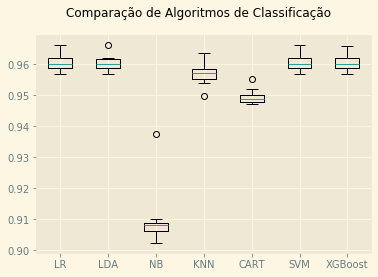

In [29]:
# Preparando a lista de modelos
modelos = []
modelos.append(('LR', LogisticRegression()))
modelos.append(('LDA', LinearDiscriminantAnalysis()))
modelos.append(('NB', GaussianNB()))
modelos.append(('KNN', KNeighborsClassifier()))
modelos.append(('CART', DecisionTreeClassifier()))
modelos.append(('SVM', SVC()))
modelos.append(('XGBoost', xgb.XGBClassifier()))

# Avaliando cada modelo em um loop
resultados = []
nomes = []

for nome, modelo in modelos:
    kfold = KFold(n_splits = num_folds, random_state = seed)
    cv_results = cross_val_score(modelo, X, Y, cv = kfold, scoring = 'accuracy')
    resultados.append(cv_results)
    nomes.append(nome)
    msg = "%s: %f (%f)" % (nome, cv_results.mean(), cv_results.std())
    print(msg)

# Boxplot para comparar os algoritmos
fig = plt.figure()
fig.suptitle('Comparação de Algoritmos de Classificação')
ax = fig.add_subplot(111)
plt.boxplot(resultados)
ax.set_xticklabels(nomes)
plt.show()

Com os dados normalizados, Todos os algoritimos tiveram uma boa performance, retirando o NB

### Dados Padronizados

#### Separação dos Dados Entre Treino e Teste

In [30]:
# Carregando os dados
array = VarTreinoPadronizadas[rfeVAR].values

# Separando o array em componentes de input e output
X = array[:,0:5]
Y = targetTreino

# Definindo os valores para os folds
num_folds = 10
seed = 7

# Separando os dados em folds
kfold = KFold(num_folds, True, random_state = seed)

##### Realizando os testes com diversos modelos classificativos

LR: 0.960471 (0.002493)
LDA: 0.960401 (0.002434)
NB: 0.910101 (0.009387)
KNN: 0.956342 (0.004616)
CART: 0.949195 (0.002720)
SVM: 0.960471 (0.002493)
XGBoost: 0.960274 (0.002547)


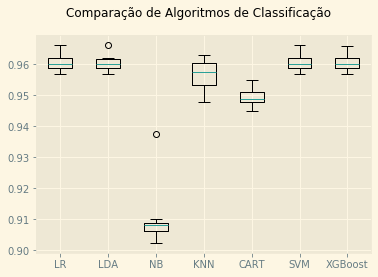

In [64]:
# Preparando a lista de modelos
modelos = []
modelos.append(('LR', LogisticRegression()))
modelos.append(('LDA', LinearDiscriminantAnalysis()))
modelos.append(('NB', GaussianNB()))
modelos.append(('KNN', KNeighborsClassifier()))
modelos.append(('CART', DecisionTreeClassifier()))
modelos.append(('SVM', SVC()))
modelos.append(('XGBoost', xgb.XGBClassifier()))

# Avaliando cada modelo em um loop
resultados = []
nomes = []

for nome, modelo in modelos:
    kfold = KFold(n_splits = num_folds, random_state = seed)
    cv_results = cross_val_score(modelo, X, Y, cv = kfold, scoring = 'accuracy')
    resultados.append(cv_results)
    nomes.append(nome)
    msg = "%s: %f (%f)" % (nome, cv_results.mean(), cv_results.std())
    print(msg)

# Boxplot para comparar os algoritmos
fig = plt.figure()
fig.suptitle('Comparação de Algoritmos de Classificação')
ax = fig.add_subplot(111)
plt.boxplot(resultados)
ax.set_xticklabels(nomes)
plt.show()

Com os dados Padronizados, os melhores algoritimos foram os:
###### Regressão Logistica, SVM e XGB

### Rebalanceando a classes de clientes

Como apenas ~4% dos dados são clientes insatisfeitos, pode acontecer do nosso algoritimo aprender muito como identificar clientes satisfeitos porém não conseguir realizar uma boa previsão para clientes insatisfeitos. 

Essa técnica ela pode funcionar muito bem, como não...

Para descobrir se é o caso, apenas realizando os testes. No caso vou utilizar a técnica do Near Miss.Essa técnica excluir os dados de forma totalmente aleatoria até rebalencear as classes

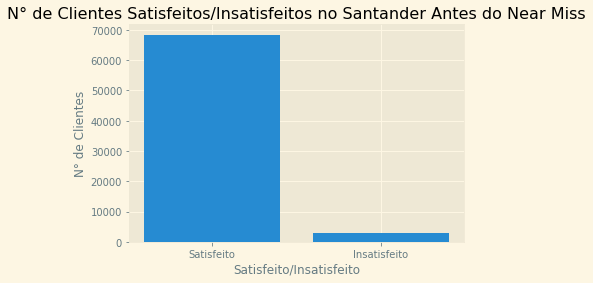

In [32]:
grupos = ['Satisfeito', 'Insatisfeito']
valores = df['TARGET'].value_counts().values

# Construção do gráfico
plt.style.use("Solarize_Light2")
plt.bar(grupos, valores)
plt.title('N° de Clientes Satisfeitos/Insatisfeitos no Santander Antes do Near Miss')
plt.ylabel('N° de Clientes')
plt.xlabel('Satisfeito/Insatisfeito')
plt.show()

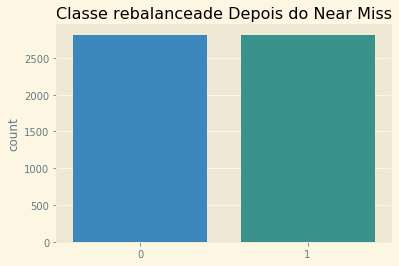

In [33]:
# Criando a instancia
nr = NearMiss()

# Carregando os dados
array = VarTreino[rfeVAR].values

# Separando o array em componentes de input e output
X = array[:,0:5]
Y = targetTreino

VarTreinoMiss, targetTreinoMiss = nr.fit_sample(X, Y)

sns.countplot(targetTreinoMiss)
plt.title('Classe rebalanceade Depois do Near Miss')
plt.show()

#### Separação dos Dados Entre Treino e Teste

In [34]:
# Carregando os dados
array = VarTreinoMiss

# Separando o array em componentes de input e output
X = array[:,0:5]
Y = targetTreinoMiss

# Definindo os valores para os folds
num_folds = 10
seed = 7

# Separando os dados em folds
kfold = KFold(num_folds, True, random_state = seed)

##### Realizando os testes com diversos modelos classificativos

LR: 0.713677 (0.098286)
LDA: 0.703375 (0.128833)
NB: 0.601421 (0.377461)
KNN: 0.662877 (0.278474)
CART: 0.781350 (0.025238)
SVM: 0.040853 (0.041145)
XGBoost: 0.788099 (0.030786)


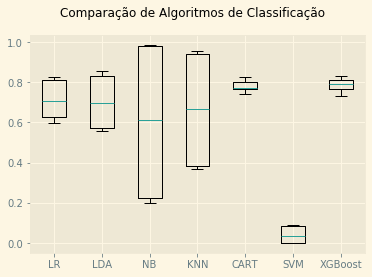

In [35]:
# Preparando a lista de modelos
modelos = []
modelos.append(('LR', LogisticRegression()))
modelos.append(('LDA', LinearDiscriminantAnalysis()))
modelos.append(('NB', GaussianNB()))
modelos.append(('KNN', KNeighborsClassifier()))
modelos.append(('CART', DecisionTreeClassifier()))
modelos.append(('SVM', SVC()))
modelos.append(('XGBoost', xgb.XGBClassifier()))

# Avaliando cada modelo em um loop
resultados = []
nomes = []

for nome, modelo in modelos:
    kfold = KFold(n_splits = num_folds, random_state = seed)
    cv_results = cross_val_score(modelo, X, Y, cv = kfold, scoring = 'accuracy')
    resultados.append(cv_results)
    nomes.append(nome)
    msg = "%s: %f (%f)" % (nome, cv_results.mean(), cv_results.std())
    print(msg)

# Boxplot para comparar os algoritmos
fig = plt.figure()
fig.suptitle('Comparação de Algoritmos de Classificação')
ax = fig.add_subplot(111)
plt.boxplot(resultados)
ax.set_xticklabels(nomes)
plt.show()

Na primeira fase de testes, podemos verificar que os modelos NB, KNN, CART não consguiram realizar uma boa performance, por este motivo estarei excluindo eles da próxima fase de testes.

Outra conclusão que podemos perceber é que com os Dados Padronizados, conseguimos obter os melhores resultados e por este motivo estarei utilizando os dados padronizados

### Avalição Detalhada dos Melhores Modelos

##### Regressão Logistica

In [36]:
# Curva ROC 
# A Curva ROC permite analisar a métrica AUC (Area Under the Curve).
# Essa é uma métrica de performance para classificação binária, em que podemos definir as classes em positiavs e negativas.
# Problemas de classificação binária são um trade-off sentre Sensitivity e Specifity.
# Sensitivity é a taxa de verdadeiros positivos (TP). Ese é o número de instâncias positivas da primeira classe que foram previstas corretamente.
# Specifity é a taxa de verdadeiros negativos (TN). Esse é o número de instâncias da segunda classe que foram previstas corretamente.
# Valores acima de 0.5 indicam uma boa taxa de previsão.

# Carregando os dados
array = VarTreinoPadronizadas[rfeVAR].values

# Separando o array em componentes de input e output
X = array[:,0:5]
Y = targetTreino

# Definindo os valores para os folds
num_folds = 10
seed = 7

# Separando os dados em folds
kfold = KFold(num_folds, True, random_state = seed)

# Criando o modelo
model = LogisticRegression()

# Cross Validation
resultado = cross_val_score(model, X, Y, cv = kfold, scoring = 'roc_auc')

# Guardando resultado
ROCRegression = resultado.mean()*100

# Print do resultado
print("AUC: %.3f" % (resultado.mean() * 100))

AUC: 75.464


In [37]:
# Confusion Matrix
# Permite verificar a acurácia em um formato de tabela
# Carregando os dados
array = VarTreinoPadronizadas[rfeVAR].values

# Separando o array em componentes de input e output
X = array[:,0:5]
Y = targetTreino

# Definindo o tamanho do conjunto de dados
teste_size = 0.33
seed = 7

# Dividindo os dados em treino e teste
X_treino, X_teste, Y_treino, Y_teste = train_test_split(VarTreinoPadronizadas[rfeVAR], targetTreino, test_size = teste_size, 
                                                        random_state = seed)

# Criando o modelo
model = LogisticRegression()
model.fit(X_treino, Y_treino)

# Fazendo as previsões e construindo a Confusion Matrix
previsoes = model.predict(X_teste)
matrixRegression = confusion_matrix(Y_teste, previsoes)

# Imprimindo a Confusion Matrix
print(matrixRegression)

[[22610     0]
 [  891     0]]


In [38]:
# Relatório de Classificação

# Fazendo as previsões e construindo o relatório
previsoes = model.predict(X_teste)
reportRegression = classification_report(Y_teste, previsoes)


# Imprimindo o relatório
print(reportRegression)

              precision    recall  f1-score   support

           0       0.96      1.00      0.98     22610
           1       0.00      0.00      0.00       891

    accuracy                           0.96     23501
   macro avg       0.48      0.50      0.49     23501
weighted avg       0.93      0.96      0.94     23501



##### SVM

In [39]:
# Carregando os dados
array = VarTreinoPadronizadas[rfeVAR].values

# Separando o array em componentes de input e output
X = array[:,0:5]
Y = targetTreino

# Definindo os valores para os folds
num_folds = 10
seed = 7

# Separando os dados em folds
kfold = KFold(num_folds, True, random_state = seed)

# Criando o modelo
model = SVC()

# Cross Validation
resultado = cross_val_score(model, X, Y, cv = kfold, scoring = 'roc_auc')

ROCSvm = resultado.mean() * 100

# Print do resultado
print("AUC: %.3f" % (resultado.mean() * 100))

AUC: 55.481


In [40]:
# Confusion Matrix
# Permite verificar a acurácia em um formato de tabela
# Carregando os dados
array = VarTreinoPadronizadas[rfeVAR].values

# Separando o array em componentes de input e output
X = array[:,0:5]
Y = targetTreino

# Definindo o tamanho do conjunto de dados
teste_size = 0.33
seed = 7

# Dividindo os dados em treino e teste
X_treino, X_teste, Y_treino, Y_teste = train_test_split(VarTreinoPadronizadas[rfeVAR], targetTreino, test_size = teste_size, 
                                                        random_state = seed)

# Criando o modelo
model = SVC()
model.fit(X_treino, Y_treino)

# Fazendo as previsões e construindo a Confusion Matrix
previsoes = model.predict(X_teste)
matrixSvm = confusion_matrix(Y_teste, previsoes)

# Imprimindo a Confusion Matrix
print(matrixSvm)

[[22610     0]
 [  891     0]]


In [41]:
# Relatório de Classificação

# Fazendo as previsões e construindo o relatório
previsoes = model.predict(X_teste)
reportSvm = classification_report(Y_teste, previsoes)

# Imprimindo o relatório
print(reportSvm)

              precision    recall  f1-score   support

           0       0.96      1.00      0.98     22610
           1       0.00      0.00      0.00       891

    accuracy                           0.96     23501
   macro avg       0.48      0.50      0.49     23501
weighted avg       0.93      0.96      0.94     23501



##### XGBoost

In [42]:
# Carregando os dados
array = VarTreinoPadronizadas[rfeVAR].values

# Separando o array em componentes de input e output
X = array[:,0:5]
Y = targetTreino

# Definindo os valores para os folds
num_folds = 10
seed = 7

# Separando os dados em folds
kfold = KFold(num_folds, True, random_state = seed)

# Criando o modelo
model = xgb.XGBClassifier()

# Cross Validation
resultado = cross_val_score(model, X, Y, cv = kfold, scoring = 'roc_auc')
ROCXgb = resultado.mean() * 100

# Print do resultado
print("AUC: %.3f" % (resultado.mean() * 100))

AUC: 81.243


In [43]:
# Confusion Matrix
# Permite verificar a acurácia em um formato de tabela
# Carregando os dados
array = VarTreinoPadronizadas[rfeVAR].values

# Separando o array em componentes de input e output
X = array[:,0:5]
Y = targetTreino

# Definindo o tamanho do conjunto de dados
teste_size = 0.33
seed = 7

# Dividindo os dados em treino e teste
X_treino, X_teste, Y_treino, Y_teste = train_test_split(VarTreinoPadronizadas[rfeVAR], targetTreino, test_size = teste_size, 
                                                        random_state = seed)

# Criando o modelo
model = xgb.XGBClassifier()
model.fit(X_treino, Y_treino)

# Fazendo as previsões e construindo a Confusion Matrix
previsoes = model.predict(X_teste)
matrixXgb = confusion_matrix(Y_teste, previsoes)

# Imprimindo a Confusion Matrix
print(matrixXgb)

[[22597    13]
 [  889     2]]


In [44]:
# Relatório de Classificação

# Fazendo as previsões e construindo o relatório
previsoes = model.predict(X_teste)
reportXgb = classification_report(Y_teste, previsoes)

# Imprimindo o relatório
print(reportXgb)

              precision    recall  f1-score   support

           0       0.96      1.00      0.98     22610
           1       0.13      0.00      0.00       891

    accuracy                           0.96     23501
   macro avg       0.55      0.50      0.49     23501
weighted avg       0.93      0.96      0.94     23501



### Realizando a comparação entre os modelos

##### Curva ROC

In [45]:
print('Regressão Logistica', round(ROCRegression, 3))
print('SVM', round(ROCSvm, 3))
print('XGB', round(ROCXgb,3))

Regressão Logistica 75.464
SVM 55.481
XGB 81.243


##### Confusion Matrix

In [46]:
print('\t Regressão Logistica')
print(matrixRegression, '\n')
print('\t SVM')
print(matrixSvm, '\n')
print('\t XGB')
print(matrixXgb)

	 Regressão Logistica
[[22610     0]
 [  891     0]] 

	 SVM
[[22610     0]
 [  891     0]] 

	 XGB
[[22597    13]
 [  889     2]]


##### Report

In [47]:
print('\t \t Regressão Logistica')
print(reportRegression, '\n')
print('\t \t SVM')
print(reportSvm, '\n')
print('\t \t XGB')
print(reportXgb)

	 	 Regressão Logistica
              precision    recall  f1-score   support

           0       0.96      1.00      0.98     22610
           1       0.00      0.00      0.00       891

    accuracy                           0.96     23501
   macro avg       0.48      0.50      0.49     23501
weighted avg       0.93      0.96      0.94     23501
 

	 	 SVM
              precision    recall  f1-score   support

           0       0.96      1.00      0.98     22610
           1       0.00      0.00      0.00       891

    accuracy                           0.96     23501
   macro avg       0.48      0.50      0.49     23501
weighted avg       0.93      0.96      0.94     23501
 

	 	 XGB
              precision    recall  f1-score   support

           0       0.96      1.00      0.98     22610
           1       0.13      0.00      0.00       891

    accuracy                           0.96     23501
   macro avg       0.55      0.50      0.49     23501
weighted avg       0.93      0

Como podemos ver, o algoritimo XGB conseguiu se sair superior em todas as metricas utilizadas. Por este motivo vou utilizar esse algortimo para a próxima etapa

## Realizando Previsões e Testes Direto no Site Kaggle

### Primeira tentativa será utilizando os Dados Normalizadas

In [48]:
# Normalizando os dados de TESTE

scaler = MinMaxScaler()

# Aplicando a escala no Dataset
VarTesteNormalizadas = scaler.fit_transform(VarTeste[rfeVAR])

# Criando um DataFrame com os resultados obtidos.
VarTesteNormalizadas = pd.DataFrame(data = VarTesteNormalizadas, columns = rfeVAR)

VarTesteNormalizadas.head()

,var15,ind_var26_cte,num_var42_0,saldo_var30,saldo_medio_var5_hace2
0,0.27,0.0,0.066667,0.000943,0.002324
1,0.30,0.0,0.066667,0.000943,0.002319
2,0.18,0.0,0.066667,0.000949,0.002447
3,0.19,0.0,0.066667,0.000942,0.002315
4,0.18,0.0,0.066667,0.000949,0.002359


In [49]:
# Carregando os dados
array = VarTreinoNormalizadas[rfeVAR].values

# Separando o array em componentes de input e output
X = array[:,0:5]
Y = targetTreino

# Definindo o tamanho do conjunto de dados
teste_size = 0.33
seed = 7

# Dividindo os dados em treino e teste
X_treino, X_teste, Y_treino, Y_teste = train_test_split(VarTreinoNormalizadas[rfeVAR], targetTreino, test_size = teste_size, 
                                                        random_state = seed)

# Criando o modelo
model = xgb.XGBClassifier()
model.fit(X_treino, Y_treino)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [50]:
# Salvando as previsões feitas pelo classificador, para o conjunto de teste em um arquivo CSV.

pd.DataFrame({
    'ID'    : testeID,
    'TARGET': model.predict_proba(VarTesteNormalizadas)[:, 1]
}).to_csv('previsoes/XGB_normalizada.csv', index = False)

##### Utilizando os Dados Normalizados, foi possivel obter um score de 0.72634 

### Segunda tentativa será utilizando os Dados Padronizados

In [51]:
# Padronizando os dados de TESTE

scaler = StandardScaler()

# Aplicando a escala no Dataset
VarTestePadronizadas = scaler.fit_transform(VarTeste[rfeVAR])

# Criando um DataFrame com os resultados obtidos.
VarTestePadronizadas = pd.DataFrame(data = VarTestePadronizadas, columns = rfeVAR)

VarTestePadronizadas.head()

,var15,ind_var26_cte,num_var42_0,saldo_var30,saldo_medio_var5_hace2
0,-0.088064,-0.173677,-0.234522,-0.213010,-0.134997
1,0.143920,-0.173677,-0.234522,-0.213056,-0.135246
2,-0.784016,-0.173677,-0.234522,-0.212646,-0.128011
3,-0.706688,-0.173677,-0.234522,-0.213101,-0.135496
4,-0.784016,-0.173677,-0.234522,-0.212646,-0.133001


In [52]:
# Carregando os dados
array = VarTreinoPadronizadas[rfeVAR].values

# Separando o array em componentes de input e output
X = array[:,0:5]
Y = targetTreino

# Definindo o tamanho do conjunto de dados
teste_size = 0.33
seed = 7

# Dividindo os dados em treino e teste
X_treino, X_teste, Y_treino, Y_teste = train_test_split(VarTreinoPadronizadas[rfeVAR], targetTreino, test_size = teste_size, 
                                                        random_state = seed)

# Criando o modelo
model = xgb.XGBClassifier()
model.fit(X_treino, Y_treino)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [53]:
# Salvando as previsões feitas pelo classificador, para o conjunto de teste em um arquivo CSV.

pd.DataFrame({
    'ID'    : testeID,
    'TARGET': model.predict_proba(VarTestePadronizadas)[:, 1]
}).to_csv('previsoes/XGB_padronizada.csv', index = False)

##### Utilizando os Dados Padronizados, foi possivel obter um score de 0.77629

### Terceira tentativa será utilizando os Dados Padronizados com o Near Miss

In [54]:
# Criando a instancia
nr = NearMiss()

# Carregando os dados
array = VarTreinoPadronizadas[rfeVAR].values

# Separando o array em componentes de input e output
X = array[:,0:5]
Y = targetTreino

VarTreinoNormalMiss, targetTreinoNormalMiss = nr.fit_sample(X, Y)

In [55]:
# Carregando os dados
array = VarTreinoNormalMiss

# Separando o array em componentes de input e output
X = array[:,0:5]
Y = targetTreinoNormalMiss

# Definindo o tamanho do conjunto de dados
teste_size = 0.33
seed = 7

# Dividindo os dados em treino e teste
X_treino, X_teste, Y_treino, Y_teste = train_test_split(VarTreinoNormalMiss, targetTreinoNormalMiss, test_size = teste_size, 
                                                        random_state = seed)

# Criando o modelo
model = xgb.XGBClassifier()
model.fit(X_treino, Y_treino)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [56]:
# Salvando as previsões feitas pelo classificador, para o conjunto de teste em um arquivo CSV.

pd.DataFrame({
    'ID'    : testeID,
    'TARGET': model.predict_proba(VarTestePadronizadas)[:, 1]
}).to_csv('previsoes/XGB_Padronizada_NearMiss.csv', index = False)

##### Utilizando os Dados Padronizados com o Near Miss, foi possivel obter um score de 0.72431

Após essa rodada de teste, é possivel perceber que o melhor resultado foi com os Dados Padronizados

Para melhorar ainda mais a perfomance do meu algoritmo, irei utilizar o grid para otimizar os parametros

# Otimização De Ajustes

In [57]:
# Definindo qual conjunto de dados de treino, já escalado, deve ser utilizado e a sua variável target.
X = VarTreinoPadronizadas[rfeVAR]
Y = targetTreino

# Definindo qual conjunto de dados de teste, já escalado, deve ser utilizado e a sua variável target.
testX = VarTestePadronizadas

# Definindo os valores que devem ser testados, em cada um dos parâmetros do modelo especificado.
paramGrid = dict (
    missing          = [np.nan],
    max_depth        = [4, 5, 6], 
    n_estimators     = [340, 350, 360], 
    learning_rate    = [0.03], 
    nthread          = [4], 
    subsample        = [0.94, 0.95], 
    colsample_bytree = [0.85], 
    seed             = [100]
)

# Criando uma instância da classe do modelo Random Forest.
model = xgb.XGBClassifier()

# Criando o grid, para fazer a busca dos melhores parâmetros para o modelo.
grid = GridSearchCV(estimator = model, param_grid = paramGrid, cv = 10, verbose = True, n_jobs = -1)

# Buscando pelos melhores parâmetros para o modelo.
grid.fit(X, Y)

# Exibindo a configuração, do melhor modelo treinado.
print("\n" + "Melhores Parâmetros para o Modelo:" + "\n\n", grid.best_estimator_)

Fitting 10 folds for each of 18 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  8.5min finished



Melhores Parâmetros para o Modelo:

 XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.85, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.03, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=360, n_jobs=4, nthread=4, num_parallel_tree=1,
              random_state=100, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=100, subsample=0.94, tree_method='exact',
              validate_parameters=1, verbosity=None)


In [65]:
# Criando o modelo, com a melhor configuração encontrada.
classifierXGB = grid.best_estimator_

# Criando dados de treino e de validação.
X_treino, X_teste, Y_treino, Y_teste = train_test_split(X, Y, test_size = 0.3)

# Treinando o modelo.
classifierXGB.fit (
    X                     = X_treino, 
    y                     = Y_treino,
    early_stopping_rounds = 20,
    eval_metric           = "auc", 
    eval_set              = [(X_teste, Y_teste)]
)

[0]	validation_0-auc:0.80546
Will train until validation_0-auc hasn't improved in 20 rounds.
[1]	validation_0-auc:0.80837
[2]	validation_0-auc:0.80881
[3]	validation_0-auc:0.81585
[4]	validation_0-auc:0.81762
[5]	validation_0-auc:0.81788
[6]	validation_0-auc:0.81918
[7]	validation_0-auc:0.81876
[8]	validation_0-auc:0.81819
[9]	validation_0-auc:0.81927
[10]	validation_0-auc:0.81929
[11]	validation_0-auc:0.81945
[12]	validation_0-auc:0.82000
[13]	validation_0-auc:0.82020
[14]	validation_0-auc:0.82031
[15]	validation_0-auc:0.82069
[16]	validation_0-auc:0.82134
[17]	validation_0-auc:0.82118
[18]	validation_0-auc:0.82105
[19]	validation_0-auc:0.82063
[20]	validation_0-auc:0.82113
[21]	validation_0-auc:0.82095
[22]	validation_0-auc:0.82110
[23]	validation_0-auc:0.82127
[24]	validation_0-auc:0.82169
[25]	validation_0-auc:0.82188
[26]	validation_0-auc:0.82219
[27]	validation_0-auc:0.82161
[28]	validation_0-auc:0.82184
[29]	validation_0-auc:0.82262
[30]	validation_0-auc:0.82295
[31]	validation_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.85, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.03, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=360, n_jobs=4, nthread=4, num_parallel_tree=1,
              random_state=100, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=100, subsample=0.94, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [66]:
# Calculando a acurácia e o ROC AUC do modelo, para o conjunto de dados de treino.
scoreTrainXGB  = accuracy_score(Y_treino, classifierXGB.predict(X_treino))
rocAucTrainXGB = roc_auc_score(Y_treino, classifierXGB.predict_proba(X_treino)[:,1])

# Visualizando o resultado.

print('Acurácia para os dados de treino: ' + str(round(scoreTrainXGB,3)) + '\n' + 
      'ROC AUC para os dados de treino: ' + str(round(rocAucTrainXGB,3))
)

Acurácia para os dados de treino: 0.96
ROC AUC para os dados de treino: 0.839


Apenas para termos como base, vamos realizar uma comparação da curva ROC antes da otimização e depois

In [67]:
print('Antes da Otimização', round(ROCXgb,3))
print('Depois da Otimização', round(rocAucTrainXGB,3) * 100)

Antes da Otimização 81.243
Depois da Otimização 83.89999999999999


In [68]:
# Salvando as previsões feitas pelo classificador, para o conjunto de teste em um arquivo CSV.
pd.DataFrame({
    'ID'    : testeID,
    'TARGET': classifierXGB.predict_proba(VarTestePadronizadas)[:, 1]
}).to_csv('previsoes/Final.csv', index = False)

Com esse modelo foi possivel obter uma métrica de 0.79307 de Score no Kaggle, conseguindo atingir nosso objetivo que era de pelo menos 0.7

# FIM

### Muito Obrigado